# Hillary Clinton's Emails

[Kaggle](https://www.kaggle.com), as part of a [competition](https://www.kaggle.com/c/hillary-clinton-emails), made available over 7,000 pages of emails sent by Hillary Clinton and her associates. I found the emails fascinating not just because of the content but because they told a story about the inner workings of Clinton's inner circle. I used network analysis and matplotlib to visually demonstrate how Clinton's inner cirlce operated. Below, I demonstrate how I created this analysis.

Import all necessary libraries as per below:

In [29]:
import pandas as pd
import sqlite3
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline 

Kaggle released a [SQLite database](https://www.kaggle.com/c/hillary-clinton-emails/data) that contains all the data needed for this analysis. I downloaded the file and convereted it to a dataframe. The other data sets are Aliases, EmailReceivers, Emails, Persons. To learn more about the different data sets, visit [Kaggle](https://www.kaggle.com/c/hillary-clinton-emails/data).

In [30]:
db = 'data_files/database.sqlite'

con = sqlite3.connect(db)
df = pd.read_sql_query("SELECT * from Emails", con)

con.close()

### Data Munging and Merging tables

At this point, the data was still messy and needed further cleaning (e.g., Hillary Clinton's could be referred to as 'H', ';H', or 'Clinton, Hillary Rodham'. However, each person had a PersonId (for Hillary Clinton, it is 80). Below, I demonstrate how I merged data with different tables to get the correct full name matched with the correct PersonId and produce a clean table to to create graphs.

In [31]:
# Create new dataframe (hf) that excludes missing values in MetadataFrom column.

hf = df[df['MetadataFrom'] != '']
hf.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,,"Sullivan, Jacob J <Sullivan11@state.gov>",,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,,UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,,,,,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...
5,6,C05739559,MEET THE RIGHT-WING EXTREMIST BEHIND ANTI-MUSL...,Russorv@state.gov,H,80,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739559...,F-2015-04841,...,,,,"Wednesday, September 12, 2012 01:00 PM",F-2015-04841,C05739559,05/13/2015,RELEASE IN PART,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


In [32]:
# In the hf dataframe only show the columns in features and rename MetadataTo to Alias to merge with the 
# Aliases df.

features = ['MetadataTo','MetadataFrom','SenderPersonId','ExtractedBodyText']

hf = hf[features]
hf = pd.DataFrame(hf)
hf.head()

,MetadataTo,MetadataFrom,SenderPersonId,ExtractedBodyText
0,H,"Sullivan, Jacob J",87,
2,;H,"Mills, Cheryl D",32,Thx
3,H,"Mills, Cheryl D",32,
4,"Abedin, Huma",H,80,"H <hrod17@clintonemail.com>\nFriday, March 11,..."
5,Russorv@state.gov,H,80,Pis print.\n-•-...-^\nH < hrod17@clintonernail...


In [33]:
# Create a new dataframe from hf that contains the name (MetadataFrom) and the PersonID. 
# Add only unique values in this dataframe.

names_df = hf
names_features = ['MetadataFrom','SenderPersonId']
names_df = names_df[names_features]
names_df = names_df.drop_duplicates()
names_df.head()

,MetadataFrom,SenderPersonId
0,"Sullivan, Jacob J",87
2,"Mills, Cheryl D",32
4,H,80
13,"Slaughter, Anne-Marie",10
15,"Koh, Harold Hongju",77


In [34]:
# In names_df, change MetadataFrom column name to MetaDataTo, to merge with hf.

names_df = names_df.rename(columns =({'MetadataFrom':'MetadataTo', 'SenderPersonId':'ReceiverPersonId'}))
names_df.head()

,MetadataTo,ReceiverPersonId
0,"Sullivan, Jacob J",87
2,"Mills, Cheryl D",32
4,H,80
13,"Slaughter, Anne-Marie",10
15,"Koh, Harold Hongju",77


In [35]:
# Merge hf dataframe with names_df on MetadataTo column.

merged_hf = hf.merge(names_df, on='MetadataTo', how='left')
merged_features = ['MetadataTo','MetadataFrom','ReceiverPersonId','SenderPersonId','ExtractedBodyText']
merged_hf = merged_hf[merged_features]
merged_hf.head()

,MetadataTo,MetadataFrom,ReceiverPersonId,SenderPersonId,ExtractedBodyText
0,H,"Sullivan, Jacob J",80,87,
1,;H,"Mills, Cheryl D",NaN,32,Thx
2,H,"Mills, Cheryl D",80,32,
3,"Abedin, Huma",H,81,80,"H <hrod17@clintonemail.com>\nFriday, March 11,..."
4,Russorv@state.gov,H,NaN,80,Pis print.\n-•-...-^\nH < hrod17@clintonernail...


In [36]:
# The merged_hf dataframe is missing many 1,641 emails (174 names) because of inconsistencies in naming.
# They are identified below.

find_nulls = merged_hf[merged_hf.ReceiverPersonId.isnull()]
find_nulls_feature = ['MetadataTo']
find_nulls = find_nulls[find_nulls_feature]
find_nulls = find_nulls.drop_duplicates()
find_nulls.head()

,MetadataTo
1,;H
4,Russorv@state.gov
17,sullivanjj@state.gov
38,"Flores, Oscar"
74,abedinh@state.gov


In [37]:
#Load aliases dataframe
aliases_df = pd.read_csv('data_files/Aliases.csv')

#Only include Alias and PersonId columns from Aliases df
aliases = ['Alias','PersonId']
aliases = aliases_df[aliases]

# Rename Alias column to be MetadataTo
aliases = aliases.rename(columns =({'Alias':'MetadataTo', 'PersonId':'ReceiverPersonId'}))
aliases.head()

,MetadataTo,ReceiverPersonId
0,111th congress,1
1,agna usemb kabul afghanistan,2
2,ap,3
3,asuncion,4
4,alec,5


In [38]:
# Merge the find_nulls dataframe with the Alias dataframe to get PersonId for missing Aliases.

fix_nulls_df = find_nulls.merge(aliases, on='MetadataTo', how='left')
fix_nulls_df = fix_nulls_df[fix_nulls_df.ReceiverPersonId.notnull()]
fix_nulls_df.head()

,MetadataTo,ReceiverPersonId
2,sullivanjj@state.gov,87
4,abedinh@state.gov,81
5,millscd@state.gov,32
6,hanleymr@state.gov,150
12,michele.flournoy,147


In [39]:
# Append fix_nulls_df to names_df to have a comprehensive list of names and PersonIds.

top_stack = names_df
bottom_stack = fix_nulls_df

concat_names_df = pd.concat([top_stack, bottom_stack], axis=0)
concat_names_df[concat_names_df.ReceiverPersonId.notnull()]
concat_names_df = concat_names_df.rename(columns =({'ReceiverPersonId':'ReceiverPersonIdConct'}))
concat_names_df.head()

,MetadataTo,ReceiverPersonIdConct
0,"Sullivan, Jacob J",87
2,"Mills, Cheryl D",32
4,H,80
13,"Slaughter, Anne-Marie",10
15,"Koh, Harold Hongju",77


In [40]:
# Merge the merged_hf table with the concat_names_df table to fix for missing values.

merged_hf = merged_hf.merge(concat_names_df, on='MetadataTo', how='left')
merged_hf.head()

,MetadataTo,MetadataFrom,ReceiverPersonId,SenderPersonId,ExtractedBodyText,ReceiverPersonIdConct
0,H,"Sullivan, Jacob J",80,87,,80
1,;H,"Mills, Cheryl D",NaN,32,Thx,NaN
2,H,"Mills, Cheryl D",80,32,,80
3,"Abedin, Huma",H,81,80,"H <hrod17@clintonemail.com>\nFriday, March 11,...",81
4,Russorv@state.gov,H,NaN,80,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,NaN


In [41]:
# Rearrange columns in dataframe and rename the ReceiverPersonIdConct column to ReceiverPersonId.

count_hf = merged_hf[merged_hf.ReceiverPersonIdConct.notnull()]
count_hf_features = ['MetadataTo','MetadataFrom','ReceiverPersonIdConct','SenderPersonId','ExtractedBodyText']
to_from_df = count_hf[count_hf_features]
to_from_df = to_from_df.rename(columns =({'ReceiverPersonIdConct':'ReceiverPersonId'}))
to_from_df.ReceiverPersonId = to_from_df.ReceiverPersonId.astype(int)
to_from_df.SenderPersonId = to_from_df.SenderPersonId.astype(int)
to_from_df.head()

,MetadataTo,MetadataFrom,ReceiverPersonId,SenderPersonId,ExtractedBodyText
0,H,"Sullivan, Jacob J",80,87,
2,H,"Mills, Cheryl D",80,32,
3,"Abedin, Huma",H,81,80,"H <hrod17@clintonemail.com>\nFriday, March 11,..."
5,H,"Mills, Cheryl D",80,32,
6,"Abedin, Huma",H,81,80,"H <hrod17@clintonemail.corn>\nFriday, March 11..."


In [42]:
# Create a CleanReceiverName column with correct names by merging with Persons table.

sender_persons_df = pd.read_csv('data_files/Persons.csv')
sender_persons_df = sender_persons_df.rename(columns =({'Id':'ReceiverPersonId', 'Name': 'CleanReceiverName'}))
sender_persons_df
temp_df = to_from_df.merge(sender_persons_df, on='ReceiverPersonId', how='left')
temp_df.head()

,MetadataTo,MetadataFrom,ReceiverPersonId,SenderPersonId,ExtractedBodyText,CleanReceiverName
0,H,"Sullivan, Jacob J",80,87,,Hillary Clinton
1,H,"Mills, Cheryl D",80,32,,Hillary Clinton
2,"Abedin, Huma",H,81,80,"H <hrod17@clintonemail.com>\nFriday, March 11,...",Huma Abedin
3,H,"Mills, Cheryl D",80,32,,Hillary Clinton
4,"Abedin, Huma",H,81,80,"H <hrod17@clintonemail.corn>\nFriday, March 11...",Huma Abedin


In [43]:
# Create a CleanToName column with correct names by merging with Persons table
receiver_persons_df = pd.read_csv('data_files/Persons.csv')
receiver_persons_df = receiver_persons_df.rename(columns =({'Id':'SenderPersonId', 'Name': 'CleanSenderName'}))
temp2_df = temp_df.merge(receiver_persons_df, on='SenderPersonId', how='left')
temp2_df
to_from_df = temp2_df
to_from_df.head()

,MetadataTo,MetadataFrom,ReceiverPersonId,SenderPersonId,ExtractedBodyText,CleanReceiverName,CleanSenderName
0,H,"Sullivan, Jacob J",80,87,,Hillary Clinton,Jake Sullivan
1,H,"Mills, Cheryl D",80,32,,Hillary Clinton,Cheryl Mills
2,"Abedin, Huma",H,81,80,"H <hrod17@clintonemail.com>\nFriday, March 11,...",Huma Abedin,Hillary Clinton
3,H,"Mills, Cheryl D",80,32,,Hillary Clinton,Cheryl Mills
4,"Abedin, Huma",H,81,80,"H <hrod17@clintonemail.corn>\nFriday, March 11...",Huma Abedin,Hillary Clinton


In [44]:
# Create a new column from CleanReceiverName and CleanSenderName that is (Receiver, Sender) tuple

to_from_df['Sender_Receiver'] = zip(to_from_df.CleanSenderName, to_from_df.CleanReceiverName)
to_from_df.head()

,MetadataTo,MetadataFrom,ReceiverPersonId,SenderPersonId,ExtractedBodyText,CleanReceiverName,CleanSenderName,Sender_Receiver
0,H,"Sullivan, Jacob J",80,87,,Hillary Clinton,Jake Sullivan,"(Jake Sullivan, Hillary Clinton)"
1,H,"Mills, Cheryl D",80,32,,Hillary Clinton,Cheryl Mills,"(Cheryl Mills, Hillary Clinton)"
2,"Abedin, Huma",H,81,80,"H <hrod17@clintonemail.com>\nFriday, March 11,...",Huma Abedin,Hillary Clinton,"(Hillary Clinton, Huma Abedin)"
3,H,"Mills, Cheryl D",80,32,,Hillary Clinton,Cheryl Mills,"(Cheryl Mills, Hillary Clinton)"
4,"Abedin, Huma",H,81,80,"H <hrod17@clintonemail.corn>\nFriday, March 11...",Huma Abedin,Hillary Clinton,"(Hillary Clinton, Huma Abedin)"


### Create Tuples and Dicts

To start creating graphs, first we need dicts with tuples that counts the number of emails sent between senders and receivers (e.g., {(Sender, Receiver): Count}.

In [45]:
# Make a groupby count into a dataframe to show top email pairs.

count_features = ['Sender_Receiver','MetadataTo']
to_from_count_df = to_from_df
to_from_count_df = to_from_count_df[count_features]

# Create a new dataframe that includes the count.

to_from_count_df = pd.DataFrame({'Count' : to_from_count_df.groupby(["Sender_Receiver", "MetadataTo"]).size()}).reset_index() 
count_features2 = ['Sender_Receiver', 'Count']
to_from_count_df = to_from_count_df[count_features2]
to_from_count_df = to_from_count_df.sort('Count', ascending = False).set_index('Sender_Receiver')
to_from_count_df.head()

/Users/SamK/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Count
Sender_Receiver,
"(Huma Abedin, Hillary Clinton)",1351
"(Cheryl Mills, Hillary Clinton)",1242
"(Jake Sullivan, Hillary Clinton)",839
"(Hillary Clinton, Huma Abedin)",336
"(Lauren Jiloty, Hillary Clinton)",333


In [46]:
# Create a tuple with Sender-Receiver names

sender_receiver_tuple = to_from_df.Sender_Receiver
sender_receiver_tuple[1]

('Cheryl Mills', 'Hillary Clinton')

In [47]:
# Create a dict with a count for the sender receiver pairs (e.g., {(sender, receiver): count}).

hrc_dict={}

for tup in list(to_from_df.Sender_Receiver.values):
    if tup not in hrc_dict:
        hrc_dict[tup] = 1
    else:
        hrc_dict[tup] = hrc_dict[tup] + 1   
hrc_dict['Anne-Marie Slaughter', 'Hillary Clinton']

130

In [48]:
#Create a dict of sender-receiver pairs with more than 10 emails exchanged.

hrc_graph_dict = {}
for s, r in hrc_dict:
    if hrc_dict[s,r] <= 10:
        pass
    else:
        hrc_graph_dict[s,r]=hrc_dict[s,r]

In [49]:
# Create a dict of the network with emails to or from Hillary Clinton excluded.

other_dict = {}
hill_dict = {}
for s, r in hrc_dict:
    if s == 'Hillary Clinton'or r == 'Hillary Clinton':
        pass
    elif s == r:
        pass
    elif hrc_dict[s,r]<=1:
        pass
    else:
        other_dict[s,r] = hrc_dict[s,r]

### Create Graphs

Now for the fun part, we can use the dicts to create graphs. I've created three graphs: 1) Top 15 Sender-Receiver Pairs; 2) Network of Senders and Receivers with 10 or more emails exchanged; and 3) Network of Senders and Receivers excluding emails sent or received by Hillary Clinton.

/Users/SamK/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


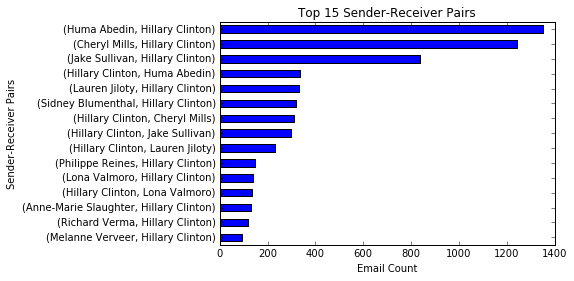

In [50]:
# Graph top 15 Sender-Receiver Pairs

my_plot = to_from_count_df.head(15)
my_plot = my_plot.sort('Count').plot(kind = 'barh', legend = None, title = 'Top 15 Sender-Receiver Pairs')
my_plot.set_xlabel('Email Count')
my_plot.set_ylabel('Sender-Receiver Pairs')
plt.show()

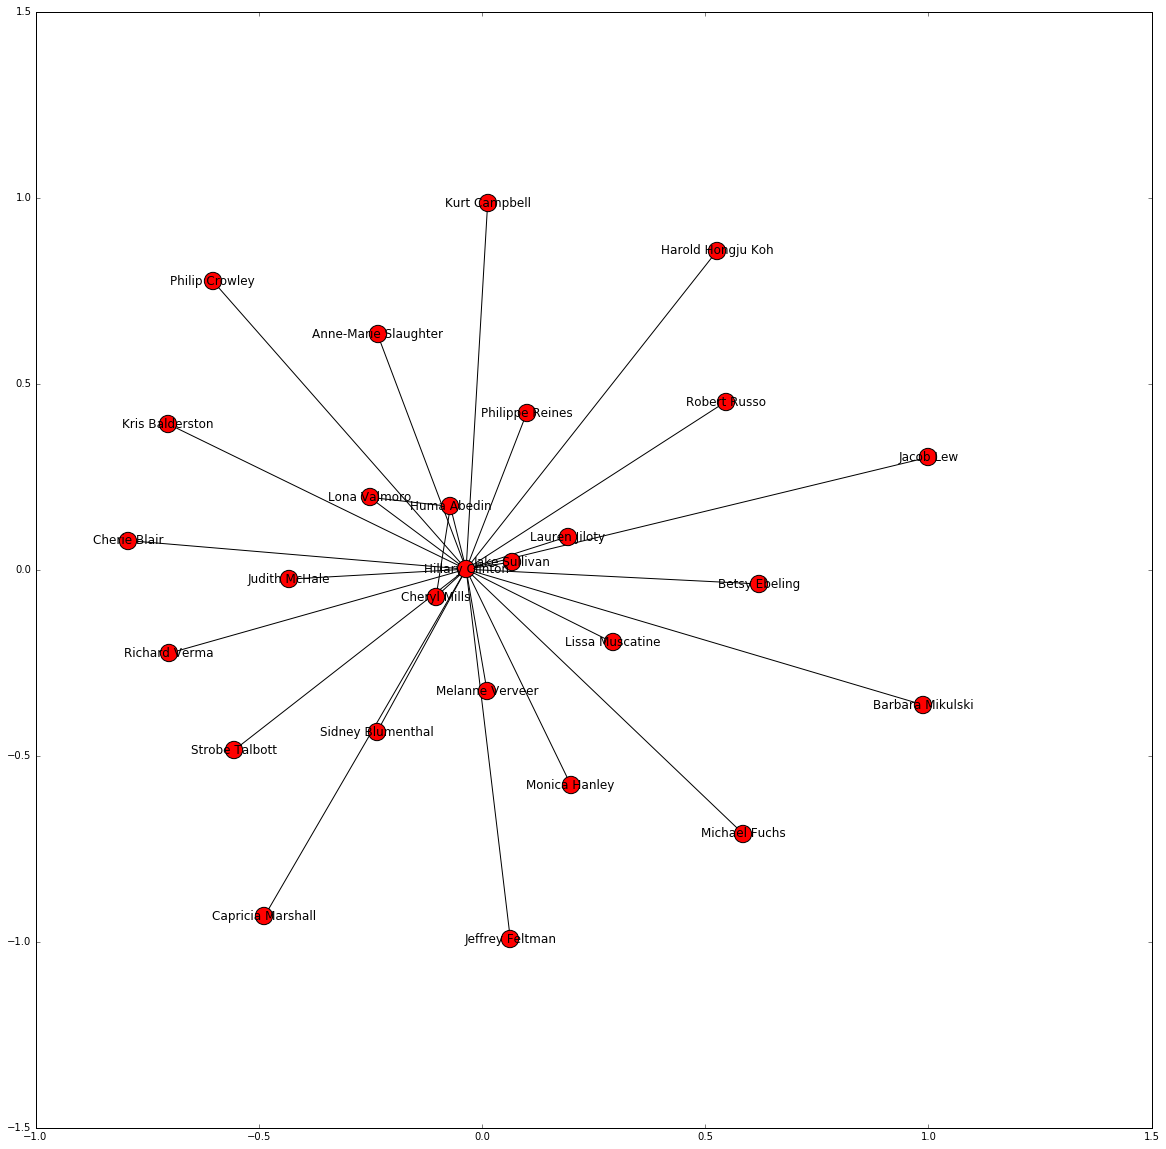

In [51]:
# Graph network of Senders and Receivers with 10 or more emails exchanged

G = nx.Graph()

for (s,r), count in hrc_graph_dict.items():
    G.add_edge(s, r, weight=count)

pos = nx.spring_layout(G)

edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])

plt.figure(1);
plt.figure(num=None, figsize=(20, 20), dpi=1200);
nx.draw_networkx(G, pos, with_labels=True)
#nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)

plt.show()


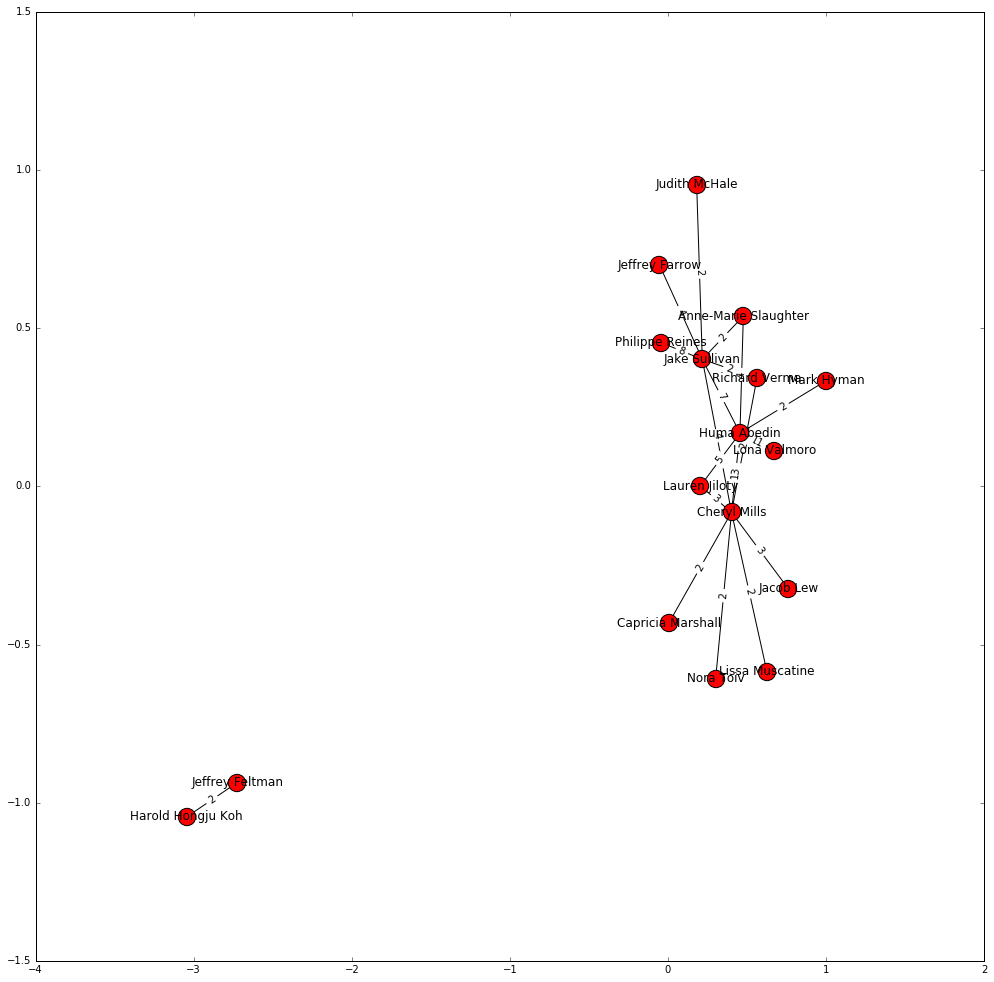

In [52]:
# Graph network of Senders and Receivers excluding emails sent or received by Hillary Clinton.

OtherG = nx.Graph()

for (s,r), count in other_dict.items():
    OtherG.add_edge(s, r, weight=count)

other_pos = nx.spring_layout(OtherG)

edge_labels=dict([((u,v,),d['weight']) for u,v,d in OtherG.edges(data=True)])

plt.figure(1);
plt.figure(num=None, figsize=(17, 17), dpi=1200);
nx.draw_networkx(OtherG, other_pos, with_labels=True)
nx.draw_networkx_edge_labels(OtherG,other_pos,edge_labels=edge_labels)

plt.show()